In [1]:
import numpy as np
import k3d
from ipywidgets import widgets, interact, HBox, VBox
import pyzed.sl as sl
from tqdm import tqdm

In [2]:
# Configuration
SVO_FILE = "../../data/HD720_SN38781663_10-23-10.svo2"

MAX_SECONDS = 10  # Only read first N seconds

# Body tracking settings
BODY_FORMAT = sl.BODY_FORMAT.BODY_34
ENABLE_BODY_FITTING = True
SKELETON_SMOOTHING = 0.5

In [3]:
# Initialize ZED
zed = sl.Camera()

init_params = sl.InitParameters()
init_params.set_from_svo_file(SVO_FILE)
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_mode = sl.DEPTH_MODE.NEURAL_PLUS
init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Z_UP

err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    raise RuntimeError(f"Failed to open SVO file: {err}")

camera_info = zed.get_camera_information()
fps = camera_info.camera_configuration.fps
total_frames = zed.get_svo_number_of_frames()
max_frames = min(int(MAX_SECONDS * fps), total_frames)

print(f"FPS: {fps}")
print(f"Total frames: {total_frames}")
print(f"Reading first {max_frames} frames ({MAX_SECONDS} seconds)")

[2026-01-25 09:51:51 UTC][ZED][INFO] Logging level INFO
FPS: 60.0
Total frames: 4026
Reading first 600 frames (10 seconds)
[2026-01-25 09:51:52 UTC][ZED][INFO] [Init]  Depth mode: NEURAL PLUS
[2026-01-25 09:51:52 UTC][ZED][INFO] [Init]  Serial Number: S/N 38781663


In [4]:
# Enable positional tracking (required for body tracking)
positional_tracking_params = sl.PositionalTrackingParameters()
positional_tracking_params.set_as_static = True
zed.enable_positional_tracking(positional_tracking_params)

# Enable body tracking
body_param = sl.BodyTrackingParameters()
body_param.enable_tracking = True
body_param.detection_model = sl.BODY_TRACKING_MODEL.HUMAN_BODY_ACCURATE
body_param.body_format = BODY_FORMAT
body_param.enable_body_fitting = ENABLE_BODY_FITTING

zed.enable_body_tracking(body_param)

body_runtime_param = sl.BodyTrackingRuntimeParameters()
body_runtime_param.detection_confidence_threshold = 40
body_runtime_param.skeleton_smoothing = SKELETON_SMOOTHING

print(f"Body format: {BODY_FORMAT}")
print(f"Body fitting: {ENABLE_BODY_FITTING}")
print(f"Skeleton smoothing: {SKELETON_SMOOTHING}")

Body format: BODY_FORMAT.BODY_34
Body fitting: True
Skeleton smoothing: 0.5


In [5]:
# Collect body tracking data with confidence values
frames_data = []
bodies = sl.Bodies()

with tqdm(total=max_frames, desc="Reading frames") as pbar:
    frame_idx = 0
    while zed.grab() == sl.ERROR_CODE.SUCCESS and frame_idx < max_frames:
        zed.retrieve_bodies(bodies, body_runtime_param)
        
        frame_bodies = {}
        for body in bodies.body_list:
            if body.tracking_state == sl.OBJECT_TRACKING_STATE.OK:
                frame_bodies[int(body.id)] = {
                    'keypoints_3d': body.keypoint.copy(),
                    'keypoint_confidence': body.keypoint_confidence.copy(),
                }
        
        frames_data.append(frame_bodies)
        frame_idx += 1
        pbar.update(1)

print(f"\nCollected {len(frames_data)} frames")
print(f"Persons detected: {set(pid for f in frames_data for pid in f.keys())}")

# Show confidence stats for first frame with data
for i, frame_bodies in enumerate(frames_data):
    if frame_bodies:
        first_person_id = list(frame_bodies.keys())[0]
        conf = frame_bodies[first_person_id]['keypoint_confidence']
        print(f"\nFrame {i}, Person {first_person_id} confidence stats:")
        print(f"  Min: {conf.min():.1f}")
        print(f"  Max: {conf.max():.1f}")
        print(f"  Mean: {conf.mean():.1f}")
        print(f"  Per keypoint: {np.round(conf, 1)}")
        break

Reading frames: 100%|█████████████████████████████████████████████| 600/600 [00:27<00:00, 21.80it/s]


Collected 600 frames
Persons detected: {0}

Frame 180, Person 0 confidence stats:
  Min: 0.0
  Max: 98.9
  Mean: 25.6
  Per keypoint: [66.4 63.5 63.5 57.7 40.4 23.   0.   0.   0.   0.   0.  63.1 68.5 98.9
 35.7 35.7 35.7 35.7 66.4 28.   0.   0.  66.4 22.6  0.   0.   0.   0.
  0.   0.   0.   0.   0.   0. ]


In [6]:
# Close ZED camera
zed.close()
print("ZED camera closed")

ZED camera closed


In [7]:
# Define bone connections based on body format
if BODY_FORMAT == sl.BODY_FORMAT.BODY_34:
    bones = [
        (0, 1), (1, 2), (2, 3), (3, 26),  # Spine to head
        (2, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (7, 10),  # Left arm
        (2, 11), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (14, 17),  # Right arm
        (0, 18), (18, 19), (19, 20), (20, 21), (20, 32),  # Left leg
        (0, 22), (22, 23), (23, 24), (24, 25), (24, 33),  # Right leg
        (26, 27), (26, 28), (26, 30), (28, 29), (30, 31),  # Face
    ]
else:
    # BODY_18
    bones = [
        (0, 1), (0, 14), (0, 15), (14, 16), (15, 17),
        (1, 2), (1, 5), (2, 8), (5, 11), (8, 11),
        (2, 3), (3, 4), (5, 6), (6, 7),
        (8, 9), (9, 10), (11, 12), (12, 13),
    ]

print(f"Bone connections: {len(bones)}")

Bone connections: 33


In [8]:
def confidence_to_color(confidence, min_conf=0, max_conf=100):
    """Convert confidence value to RGB color (red=low, green=high).
    
    Args:
        confidence: Confidence value or array of values
        min_conf: Minimum confidence for color mapping
        max_conf: Maximum confidence for color mapping
    
    Returns:
        RGB color as 0xRRGGBB integer or array of integers
    """
    # Normalize to 0-1
    conf = np.clip(confidence, min_conf, max_conf)
    t = (conf - min_conf) / (max_conf - min_conf)
    
    # Red to green gradient
    # Low confidence (t=0): red (255, 0, 0)
    # High confidence (t=1): green (0, 255, 0)
    r = ((1 - t) * 255).astype(np.uint32)
    g = (t * 255).astype(np.uint32)
    b = np.zeros_like(r, dtype=np.uint32)
    
    # Pack into 0xRRGGBB format
    colors = (r << 16) | (g << 8) | b
    return colors


# Test the color function
test_conf = np.array([0, 25, 50, 75, 100])
test_colors = confidence_to_color(test_conf)
print("Confidence to color mapping:")
for c, col in zip(test_conf, test_colors):
    print(f"  {c:3d}% -> #{col:06x}")

Confidence to color mapping:
    0% -> #ff0000
   25% -> #bf3f00
   50% -> #7f7f00
   75% -> #3fbf00
  100% -> #00ff00


In [11]:
# Create k3d plot with confidence-colored skeleton
plot = k3d.plot(grid_auto_fit=True, camera_mode='orbit')

# Add floor reference plane at z=0
floor_verts = np.array([
    [-2, -1, 0], [2, -1, 0], [2, 5, 0], [-2, 5, 0]
], dtype=np.float32)
floor_indices = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.uint32)
floor_mesh = k3d.mesh(floor_verts, floor_indices, color=0x444444, opacity=0.2, name="Floor (z=0)")
plot += floor_mesh

# Create skeleton visualization with per-point colors
# Note: k3d.points with colors requires shader='mesh' or 'flat'
joints_plot = k3d.points(
    positions=np.zeros((0, 3), dtype=np.float32),
    colors=np.zeros(0, dtype=np.uint32),
    point_size=0.04,
    shader='flat',
    name="Joints (colored by confidence)"
)
plot += joints_plot

# Create bone lines - we'll draw each bone segment separately for per-bone coloring
bone_lines = []
for i, (start_idx, end_idx) in enumerate(bones):
    line = k3d.line(
        np.zeros((2, 3), dtype=np.float32),
        color=0x808080,
        width=0.008,
        name=f"Bone {start_idx}-{end_idx}"
    )
    plot += line
    bone_lines.append(line)

# Info label
info_label = widgets.Label(value="")

def update_frame(n):
    frame_bodies = frames_data[n]
    
    if frame_bodies:
        first_person_id = list(frame_bodies.keys())[0]
        data = frame_bodies[first_person_id]
        keypoints = data['keypoints_3d'].astype(np.float32)
        confidence = data['keypoint_confidence']
        
        # Update joints with confidence colors
        colors = confidence_to_color(confidence)
        joints_plot.positions = keypoints
        joints_plot.colors = colors
        
        # Update bones - color by average confidence of endpoints
        for i, (start_idx, end_idx) in enumerate(bones):
            bone_verts = np.array([keypoints[start_idx], keypoints[end_idx]], dtype=np.float32)
            bone_lines[i].vertices = bone_verts
            
            # Average confidence of the two endpoints
            avg_conf = (confidence[start_idx] + confidence[end_idx]) / 2
            bone_color = confidence_to_color(np.array([avg_conf]))[0]
            bone_lines[i].color = int(bone_color)
        
        # Update info
        info_label.value = f"Frame {n} | Person {first_person_id} | Confidence: min={confidence.min():.0f}, max={confidence.max():.0f}, mean={confidence.mean():.0f}"
    else:
        joints_plot.positions = np.zeros((0, 3), dtype=np.float32)
        joints_plot.colors = np.zeros(0, dtype=np.uint32)
        for line in bone_lines:
            line.vertices = np.zeros((2, 3), dtype=np.float32)
        info_label.value = f"Frame {n} | No body detected"

# Slider
slider = widgets.IntSlider(
    min=0,
    max=len(frames_data)-1,
    step=1,
    value=0,
    description='Frame:',
    layout=widgets.Layout(width='100%')
)

def on_slider_change(change):
    update_frame(change['new'])

slider.observe(on_slider_change, names='value')

# Color legend
legend = widgets.HTML(
    value='<div style="font-family: monospace;">'
          '<span style="color: #ff0000;">Red = Low confidence (0%)</span> | '
          '<span style="color: #80ff00;">Yellow-Green = Medium</span> | '
          '<span style="color: #00ff00;">Green = High confidence (100%)</span>'
          '</div>'
)

# Find first frame with data and show it
first_valid_frame = 0
for i, f in enumerate(frames_data):
    if f:
        first_valid_frame = i
        break

slider.value = first_valid_frame
update_frame(first_valid_frame)

display(VBox([plot, slider, info_label, legend]))

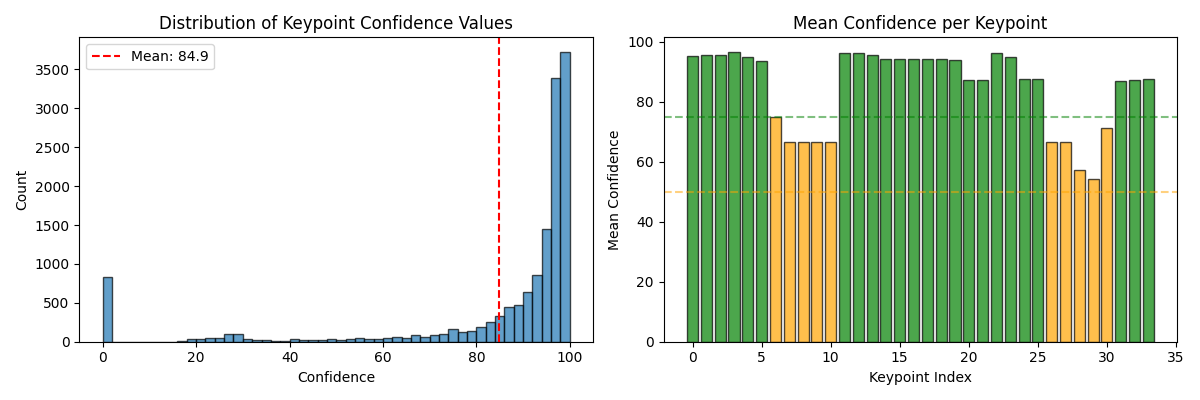

Overall confidence: min=0.0, max=99.9, mean=84.9


In [10]:
# Analyze confidence statistics across all frames
import matplotlib.pyplot as plt
%matplotlib widget

# Collect all confidence values
all_confidences = []
per_keypoint_conf = {i: [] for i in range(34 if BODY_FORMAT == sl.BODY_FORMAT.BODY_34 else 18)}

for frame_bodies in frames_data:
    for person_id, data in frame_bodies.items():
        conf = data['keypoint_confidence']
        all_confidences.extend(conf.tolist())
        for i, c in enumerate(conf):
            per_keypoint_conf[i].append(c)

all_confidences = np.array(all_confidences)

# Plot histogram of all confidence values
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Overall distribution
axes[0].hist(all_confidences, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Keypoint Confidence Values')
axes[0].axvline(all_confidences.mean(), color='r', linestyle='--', label=f'Mean: {all_confidences.mean():.1f}')
axes[0].legend()

# Per-keypoint mean confidence
keypoint_means = [np.mean(per_keypoint_conf[i]) for i in range(len(per_keypoint_conf))]
colors = ['red' if m < 50 else 'orange' if m < 75 else 'green' for m in keypoint_means]
axes[1].bar(range(len(keypoint_means)), keypoint_means, color=colors, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Keypoint Index')
axes[1].set_ylabel('Mean Confidence')
axes[1].set_title('Mean Confidence per Keypoint')
axes[1].axhline(50, color='orange', linestyle='--', alpha=0.5)
axes[1].axhline(75, color='green', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

print(f"Overall confidence: min={all_confidences.min():.1f}, max={all_confidences.max():.1f}, mean={all_confidences.mean():.1f}")